In [1]:
# this is written one month before the first working game prototype
# code needs to be updated
# this is largely for demostration and to appreciate why picking peaks in the first octave don't usually work
from IPython.display import clear_output

import pyaudio
import argparse

import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# this is the size of each individual block of audio, we call this "chunk"
chunksize = 2048

# todo: variable frequency for CQT

# parser = argparse.ArgumentParser()
# parser.add_argument("-input", required=False, type=int, help="Audio Input Device")
# args = parser.parse_args()

# # this is here so you can choose the default audio input
# if args.input is None:
#     print("No input device specified. Printing list of input devices now: ")
#     p = pyaudio.PyAudio()
#     for i in range(p.get_device_count()):
#         print("Device number (%i): %s" % (i, p.get_device_info_by_index(i).get('name')))
#         print("Run this program with -input 1, or the number of the input you'd like to use.")
#         exit()

# starting audio channel?
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
channels=1, rate=44100, input=True,
input_device_index=0, frames_per_buffer=chunksize)
time.sleep(1)

In [3]:
def detect_onset(signal, chunksize=2048, tempo_res=32, plotting = False):
    '''
    # this is to be called at the end of every chunk (2048 entries), starting from 4th chunk
    # the input to this function is four chunks
    These are never likely to be changed, maybe? : chunksize=2048, tempo_res=32
    
    TODO: make become on the fly
    '''
    # default value of onset, overwritten if onset is detected
    onset = -1

    # to detect difference
    difference = np.cumsum(np.add(np.absolute(signal[chunksize:-chunksize]), -np.absolute(signal[:-2*chunksize])))
    
    # white noise is added the the difference 
    # this is to desensitise detection of low amplitdue onset sounds
    noise = 10*np.array(np.random.randn(len(difference)))
    difference = np.add(difference, noise)

    # calculation of r-coefficient
    # -1 is negatively correlated
    # +1 is positively correlated
    # onset is when r-coefficient cuts above 0.8
    roceff = np.full(tempo_res, 0.)
    tempo_num = int(chunksize / tempo_res)
    for i in range(tempo_res):
        roceff[i] = np.corrcoef(difference[i * tempo_num:(i * tempo_num + chunksize)],
                                      np.arange(chunksize))[0, 1]
        # special case when i = 0, because we do not have the previous value
#         if i == 0 and roceff[0] > 0.8:
#             onset = i
        if roceff[0] < 0.8 and roceff[i] > 0.8 and np.max(roceff[:i]) < 0.8:
            onset = i
    
    if onset != -1:
        # clear output from jupyter
        clear_output(wait=True)
        plt.figure(figsize=(16,2))
        plt.plot(np.arange(2048*1,2048*3),np.array(difference)/np.max(difference))
        plt.plot(np.arange(2048*2,2048*3,64),roceff)
        plt.plot(signal)
        plt.axvline(x=2048*1+64*onset, color="r")
        plt.axvline(x=2048*3+64*onset, color="r")
        plt.show()
    return onset # none, or a value
           

In [4]:
def cqt_function(signal_to_ayse, plotting = False): 
    '''
    Compute the cqt response over a set of notes.

    Parameters
    ----------
    signal_to_ayse : input array, real
                     4096 entries long

    Todo
    ----
    We should not be generating the kernels every time.
    Actually we could simply multiply with the FFT of the signal.
    So:
    Make it customisable to a random starting note.
    Outsource the precomputation to a function instead - do something like load kernels.
    Do both of these at the same time.
    (but anyway we just want an accurate demo, computation time doesn't seem to be a problem here)
    '''
    
    
    length = len(signal_to_ayse)
    # print(length)

    # fast fourier transform
    freq_domain = np.fft.fft(signal_to_ayse)

    # defining the 36 notes bins
    bins = 40
    freq_ref_notes = [261.625565 * (2. ** (n/36. - 5./72.)) for n in range(bins)]
    
    # defining the time kernel
    # different note have different "kernels"
    bell_curves = []
    for note in range(len(freq_ref_notes)):
        # I don't think this is defined properly?
        bell_curve = np.exp(-((np.arange(-1.,1.,2./length))*(2.**(note/36.)))**2.)
        bell_curves.append(bell_curve)
    
    # multiplying the waveform with the window
    kernels = []
    for note in range(bins):
        # generate cosine/sine wave
        wave = np.exp((np.arange(length)-length/2.)*-1.j*2.*np.pi*freq_ref_notes[note]/44100.)
        # multiplying a window over it
        kernels.append(np.multiply(wave,bell_curves[note]))

    # taking fourier transform for the frequency kernel
    fft_kernels = []
    for note in range(bins):
        fft_kernels.append(np.fft.fft(kernels[note]))
    # all of the above should be run only once
    # but the maximum complexity is only the FFT, it is still not a problem
    # the focus is an MVP anyway
    # we prioritse accuracy here though
    
    # creating arrays to populate for each one-third-semitone
    cqt_resp_specs = []
    cqt_resp = []

    # populating the arrays
    for note in range(bins):
        cqt_resp_spec = []
        for entry in range(length):
            cqt_resp_spec.append(fft_kernels[note][entry]*freq_domain[entry])
        cqt_resp_specs.append(cqt_resp_spec)
        cqt_resp.append(sum([abs(x) for x in cqt_resp_spec]))

    # finding peaks in the cqt response
    notesrum = cqt_resp # remove redundant variable please
    
    plt.figure(figsize=(16,2))
    plt.plot(np.linspace(0, 70*44100/4096, num=70, endpoint=False), 
             np.absolute(freq_domain[:70])/np.max(np.absolute(freq_domain[:70])))
    plt.plot(np.geomspace(261.625565*2**(-3/36), 261.625565*2**(37/36), num=40, endpoint=False), 
             np.absolute(cqt_resp)/np.max(np.absolute(cqt_resp)))
    plt.show()
    
    notesrum_peak_only = [0.0]*len(notesrum)
    notesrum_sum = sum(notesrum)

    for index in range(bins-1)[1:]:
        if notesrum[index-1] < notesrum[index] and notesrum[index+1] < notesrum[index]:
            notesrum_peak_only[index]=notesrum[index]            
    

    # known_octave = notesrum_peak_only[12:12+36] # don't know what is this for
    known_octave = notesrum_peak_only[2:-2]
    # print(np.round(known_octave,5)/notesrum_sum)
    
    notesrum_peak_only_sum = sum(notesrum_peak_only)

    for x in range(36):
        # if known_octave[x]/notesrum_sum < 0.1: 
        if known_octave[x]/notesrum_peak_only_sum < 0.2: 
            known_octave[x] = 0
        
    known_octave_notes = []
    for notes in range(36//3):
        known_octave_notes.append(known_octave[3*notes]
                             +known_octave[3*notes+1]
                             +known_octave[3*notes+2])

    # notestrum_sum = sum(notesrum)  # alternate demoninator to calc threshold
    # print(np.round(known_octave_notes,5)/notesrum_peak_only_sum)
    # print("check")

    notesrum_peak_only_sum = sum(notesrum_peak_only)

    output = []

    for x in range(12):
        if known_octave_notes[x]/notesrum_peak_only_sum > 0.1:
            output.append(x+1)
            
    plt.figure(figsize=(16,2))
    plt.plot(notesrum_peak_only)
    plt.plot(notesrum)
    plt.axhline(y=0.1*notesrum_peak_only_sum, color='r', linestyle='-')
    plt.show()
    return output

In [5]:
def note_detect(chunksize=2048, tempo_res=32, plotting = False):
    print("opening")
    frames = []
    i = 0

    while True:
        # assume pyaudio clip mono sound
        # use assert?
        
        i += 1
        data = stream.read(chunksize, exception_on_overflow=False)
        data = np.fromstring(data, np.float32)
        frames.append(data)
        # print(len(frames))
        
        # start listening only after there is a certain number of "frames"
        if i > 10 and len(frames)>4:
            frames[:] = frames[-5:]
            signal = np.concatenate((frames[-5],frames[-4],frames[-3],frames[-2]))

            # onset function
            # print(np.sum(abs(signal)))
            # print(len(signal))
            # print("finding onset")
            onset = detect_onset(signal)
            # print("onset detection complete")
            # print(onset)
            
            # remove the older frames
            
            
            # make an array consists of 4096 entries if there is an onset
            if onset != -1:
                print("onset DETECTED")
                signal_ = np.concatenate((frames[-4],frames[-3],frames[-2],frames[-1]))
                signal_input = signal_[2048+64*onset:6144+64*onset]
                onset = -1 # set onset back to negative one - but necessary?

                # cqt function 
                output = cqt_function(signal_input)
                print(output)
                # convert number into note - why not just give numbers to your game?
                for i in range(len(output)):
                    if output[i] == 1:
                        output[i] = "C"
                    if output[i] == 2:
                        output[i] = "Db"
                    if output[i] == 3:
                        output[i] = "D"
                    if output[i] == 4:
                        output[i] = "Eb"
                    if output[i] == 5:
                        output[i] = "E"
                    if output[i] == 6:
                        output[i] = "F"
                    if output[i] == 7:
                        output[i] = "Gb"
                    if output[i] == 8:
                        output[i] = "G"
                    if output[i] == 9:
                        output[i] = "Ab"
                    if output[i] == 10:
                        output[i] = "A"
                    if output[i] == 11:
                        output[i] = "Bb"
                    if output[i] == 12:
                        output[i] = "B"
                print(output)    
    
    # don't you need to return something?

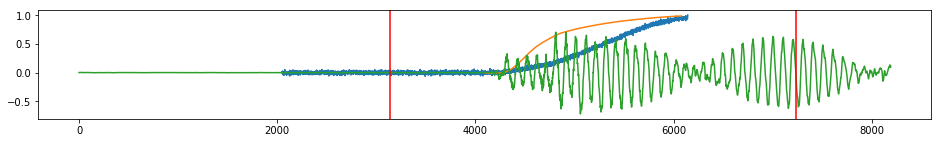

onset DETECTED


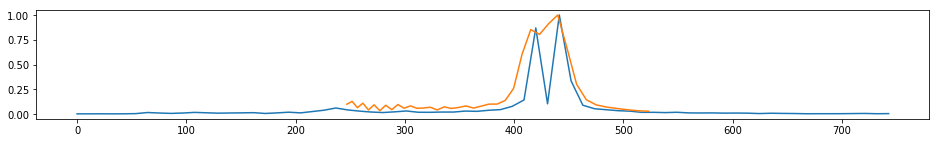

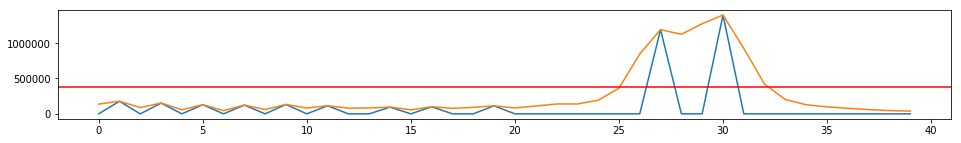

[9, 10]
['Ab', 'A']


In [ ]:
note_detect()

In [ ]:
if __name__ == "__main__":
    note_detect(plotting = False)
    
    
note_detect()